#  Classification Models

##  Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.set()

# Dimensionality reduction
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import train_test_split

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

In [2]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

In [3]:
#  Load cleaned data
df = pd.read_csv('../raw_data/clean_data.csv')
%time

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 17.2 µs


In [4]:
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,FATAL,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,1999,January,Monday,9.0,0,2.0,Right turn,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1992.0,1.0,F,33.0,Driver,Injury,Safety device used,Motor Vehicle Driver,2890
1,1999,January,Monday,9.0,0,2.0,Right turn,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1992.0,1.0,F,70.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,2890
2,1999,January,Monday,20.0,0,1.0,Ran off left shoulder,Intersection with parking lot entrance,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1988.0,1.0,F,38.0,Driver,Injury,Safety device used,Motor Vehicle Driver,4332
3,1999,January,Monday,5.0,0,2.0,Hit a moving object,At an intersection,Raining,Wet,...,Other trucks and vans,1995.0,1.0,M,34.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,5053
4,1999,January,Monday,5.0,0,2.0,Hit a moving object,At an intersection,Raining,Wet,...,Other trucks and vans,1995.0,2.0,M,30.0,"Front row, right outboard",No Injury,Safety device used,Motor Vehicle Passenger,5053


In [5]:
df.columns

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'FATAL', 'C_VEHS', 'C_CONF',
       'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE',
       'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER', 'C_CASE'],
      dtype='object')

In [6]:
df.shape

(3817613, 23)

##   Prepare data for machine learning
Since the dataset is very large to fit in a small laptop memory, training the entire dataset on a laptop will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into subsets and train the model on the small subset

In [7]:
X1, X2, y1, y2 = train_test_split(df,df.FATAL, test_size = 0.01, random_state = 42, stratify = df.FATAL)

In [8]:
print(X1.shape)
print(y1.shape)
print(X2.shape)
print(y2.shape)

(3779436, 23)
(3779436,)
(38177, 23)
(38177,)


In [9]:
X2.to_csv('../data/collision.csv', index = False)

In [10]:
# Reload data
df = pd.read_csv('../data/collision.csv')

We will perform machine learning on the smaller subset.  We create a feature matrix consisting of the predictors and a target variable which is the class to be predicted. We also drop features such as V_ID and P_ID as they are not useful in predicting the target variable

In [11]:
df.columns

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'FATAL', 'C_VEHS', 'C_CONF',
       'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE',
       'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER', 'C_CASE'],
      dtype='object')

In [12]:
# Feature matrix
X = df.drop(['P_ID', 'V_ID', 'FATAL'], axis = 1)

# Target variable
y = df['FATAL']

In [13]:
X.shape

(38177, 20)

In [14]:
y.shape

(38177,)

We now split the into $80\%$ training set and $20\%$ test set in a stratify fashion

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [16]:
print('Training set size:', X_train.shape)
print('Class training set size:', y_train.shape)
print('*************************************')
print('Test set size:', X_test.shape)
print('Class test set size:', y_test.shape)

Training set size: (30541, 20)
Class training set size: (30541,)
*************************************
Test set size: (7636, 20)
Class test set size: (7636,)


In [17]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('*********************************')
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    98.395599
1     1.604401
Name: FATAL, dtype: float64
*********************************
Test set class distribution:
 0    98.389209
1     1.610791
Name: FATAL, dtype: float64


- We can see that we still have the same class distribution as the original dataset

##  Data Pre-processing

In [18]:
# List of categorical attributes
cat_subset = list(X_train.select_dtypes('O'))

# List of numerical attributes
num_subset = list(X_train.select_dtypes('number'))

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_subset]

# Standardize the numerical attributes
num_attribs = [([num], StandardScaler()) for num in num_subset]

# Build a dataframe mapper pipeline
mapper = DataFrameMapper(cat_attribs + num_attribs)

# Fit transform the training set
X_train_scale = mapper.fit_transform(X_train)

# Only transform the training set
X_test_scale = mapper.transform(X_test)

In [19]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scale.shape)
print('Test set size after pre-processing:', X_test_scale.shape)

Training set size after pre-processing: (30541, 129)
Test set size after pre-processing: (7636, 129)


Let's convert the class labels to arrays

In [39]:
y_train = y_train.values

In [40]:
y_test = y_test.values

# Model Selection by Cross-Validation Predictions

In this section, we train two models, random forest classifier and XGBoost on the imbalanced dataset. As we shall see below, the overall accuracy of the model is not a good  performance measure for imbalanced datasets because it is bias towards the majority (negative) class. Therefore, we shall select and optimize the model with the best area under the precision-recall (AUPR) curve. 

##  1. Random Forest Classifier

In [146]:
rf = RandomForestClassifier(random_state =42)                         
model_selection_cv(rf, X_train_scale, y_train, cv_fold=5, scoring = 'accuracy')

****************************************************************************
CV score: 0.989902 (0.000606)
AUROC: 0.773770
AUPRC: 0.454625
Predicted classes: [0 1]
Confusion matrix:
 [[27477     0]
 [  282   168]]
Classification report:
              precision    recall  f1-score   support

          0       0.99      1.00      0.99     27477
          1       1.00      0.37      0.54       450

avg / total       0.99      0.99      0.99     27927

****************************************************************************


## 2. XGBoost

In [147]:
xgb_model = xgb.XGBClassifier(random_state =42)
model_selection_cv(xgb_model, X_train_scale, y_train, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
CV score: 0.990439 (0.000647)
AUROC: 0.897507
AUPRC: 0.527913
Predicted classes: [0 1]
Confusion matrix:
 [[27476     1]
 [  266   184]]
Classification report:
              precision    recall  f1-score   support

          0       0.99      1.00      1.00     27477
          1       0.99      0.41      0.58       450

avg / total       0.99      0.99      0.99     27927

****************************************************************************


- With default hyperparameters, XGBoost outperformed randon forest in all aspects

- We can see that the overall accuracy (CV score) is not a good performance measure

-  The AUROC is also very high although recall is small, so AUROC is not a good performance measure

- We shall select XBoost and optimize its AUPRC

#  Model Tuning via Grid Search and Cost Sensitive Method

 In this section, we shall optimize the AUPR of XGBoost using  randomized search cross-validation and cost sensitive method

In [148]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [149]:
# Class ratio of the negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

61.06

### First grid search

In [150]:
# First hyperparameter range
param_1 = {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}

# Gridsearch
xgb_model = xgb.XGBClassifier(n_estimators=140, subsample=0.8, colsample_bytree=0.8,random_state=42,
                         scale_pos_weight = 1)
gsearch1 = GridSearchCV(estimator = xgb_model, verbose = 1, param_grid = param_1, scoring='average_precision',
                        n_jobs = -1, cv=5)
# Fit the training set
gsearch1.fit(X_train_scale, y_train)

# Print results
print('Best score:', gsearch1.best_score_)
print('Best hyperparameters:', gsearch1.best_params_) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.1min finished


Best score: 0.5313894991996042
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 5}


### Second grid search

In [151]:
# Second hyperparameter range
param_2 = {'learning_rate': [0.05,0.1,0.3],'reg_alpha':[0,0.001,0.01]}

# Gridsearch
xgb_model = xgb.XGBClassifier(n_estimators=180, subsample=0.8, colsample_bytree=0.8,random_state=42,
                         scale_pos_weight = 1, max_depth =3, min_child_weight=5)
gsearch2 = GridSearchCV(estimator = xgb_model, verbose = 1, param_grid = param_2, scoring='average_precision',
                        n_jobs = -1, cv=5)
# Fit the training set
gsearch2.fit(X_train_scale, y_train)

# Print results
print('Best score:', gsearch2.best_score_)
print('Best hyperparameters:', gsearch2.best_params_) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.1min finished


Best score: 0.531879613881006
Best hyperparameters: {'learning_rate': 0.1, 'reg_alpha': 0.001}


### Third grid search

In [152]:
# Third hyperparameter range
param_3 = {'gamma':[i/10.0 for i in range(0,5)]}

# Gridsearch
xgb_model = xgb.XGBClassifier(n_estimators=180, subsample=0.8, colsample_bytree=0.8,random_state=42,
                         max_depth =3, min_child_weight=5, learning_rate =0.1,
                         reg_alpha =0.001,scale_pos_weight = 1)
gsearch3 = GridSearchCV(estimator = xgb_model, verbose = 1, param_grid = param_3, scoring='average_precision',
                        n_jobs = -1, cv=5)
# Fit the training set
gsearch3.fit(X_train_scale, y_train)

# Print results
print('Best score:', gsearch3.best_score_)
print('Best hyperparameters:', gsearch3.best_params_) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.9min finished


Best score: 0.531879613881006
Best hyperparameters: {'gamma': 0.0}


Let's make prediction using the best hyperparameters and boosted number of trees

In [153]:
xgb_best = xgb.XGBClassifier(n_estimators=1000, subsample=0.8, colsample_bytree=0.8,random_state=42,
                         max_depth = 3, min_child_weight=5, learning_rate =0.1,reg_alpha =0.001,
                         scale_pos_weight = class_ratio, gamma=0.0)
model_selection_cv(xgb_best, X_train_scale, y_train, cv_fold=5, scoring = 'accuracy')

****************************************************************************
CV score: 0.975078 (0.001699)
AUROC: 0.854603
AUPRC: 0.500428
Predicted classes: [0 1]
Confusion matrix:
 [[27010   467]
 [  229   221]]
Classification report:
              precision    recall  f1-score   support

          0       0.99      0.98      0.99     27477
          1       0.32      0.49      0.39       450

avg / total       0.98      0.98      0.98     27927

****************************************************************************


- There is an increase in recall from 41\% to 49\%.

# Resampling Methods

In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## 1. Under sampling of the majority class

In undersampling, we reduce the majority class such that it matches the minority class

In [154]:
# Import under sampling module from imbalanced learn
from imblearn.under_sampling import RandomUnderSampler

In [155]:
# Undersample the majority class
und = RandomUnderSampler(ratio = 'majority', random_state = 42)
X_train_scale_und, y_train_und = und.fit_sample(X_train_scale, y_train)

In [156]:
X_train_scale_und.shape

(900, 130)

In [157]:
y_train_und.shape

(900,)

In [158]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [27477   450]
Undersampled training set class distribution: [450 450]


- We can see that the majority class in the training set has been undersampled

- We now have equal class distribution. Note that the test set is not resampled

In [159]:
# Train logistic regression on the undersampled dataset
xgb_und = xgb.XGBClassifier(random_state =42)
model_selection_cv(xgb_und, X_train_scale_und, y_train_und, cv_fold=5, scoring = 'accuracy')

****************************************************************************
CV score: 0.804444 (0.026620)
AUROC: 0.887575
AUPRC: 0.907560
Predicted classes: [0 1]
Confusion matrix:
 [[387  63]
 [113 337]]
Classification report:
              precision    recall  f1-score   support

          0       0.77      0.86      0.81       450
          1       0.84      0.75      0.79       450

avg / total       0.81      0.80      0.80       900

****************************************************************************


## 2. Synthetic Minority Over Sampling Technique (SMOTE)

In SMOTE, we generate synthetic oberservations to match the minority class

In [160]:
# Import SMOTE from imbalanced learn
from imblearn.over_sampling import SMOTE

In [161]:
# Oversample the minority class
sm = SMOTE(ratio = 'minority', random_state = 42)
X_train_scale_ovsm, y_train_ovsm = sm.fit_sample(X_train_scale, y_train)

In [162]:
X_train_scale_ovsm.shape

(54954, 130)

In [163]:
y_train_ovsm.shape

(54954,)

In [164]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [27477   450]
Resampled training set class distribution: [27477 27477]


- Similarly,  SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [165]:
# Train random forest in the SMOTE dataset
xgb_ovsm = xgb.XGBClassifier(random_state =42)
model_selection_cv(xgb_ovsm, X_train_scale_ovsm, y_train_ovsm, cv_fold=5, scoring = 'accuracy')

****************************************************************************
CV score: 0.990866 (0.008997)
AUROC: 0.998331
AUPRC: 0.998739
Predicted classes: [0 1]
Confusion matrix:
 [[27404    73]
 [  429 27048]]
Classification report:
              precision    recall  f1-score   support

          0       0.98      1.00      0.99     27477
          1       1.00      0.98      0.99     27477

avg / total       0.99      0.99      0.99     54954

****************************************************************************


#  ROC and PR Curves on the Cross-Validation Training Set

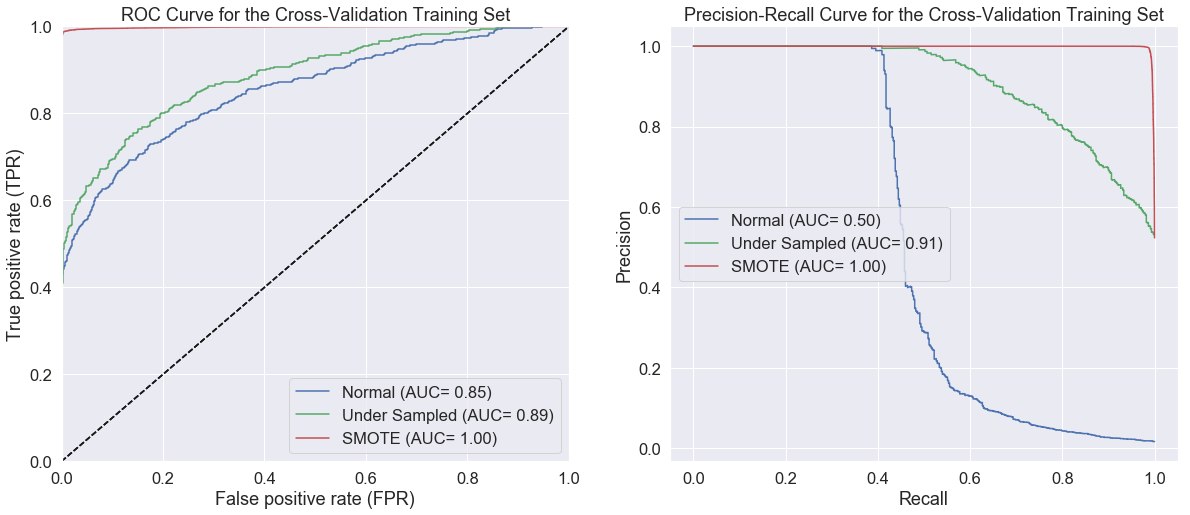

In [166]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})

# Plot ROC and PR curves for normal imbalanced distribution
xgb_best = xgb.XGBClassifier(n_estimators=1000, subsample=0.8, colsample_bytree=0.8,random_state=42,
                         max_depth =3, min_child_weight=5, learning_rate =0.1,reg_alpha =0.001,
                        scale_pos_weight = class_ratio, gamma=0.0)   

Plot_ROC_Curve_and_PRC_Cross_Val(xgb_best, X_train_scale, y_train,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Plot ROC and PR curves for Under Sampled distribution
Plot_ROC_Curve_and_PRC_Cross_Val(xgb_und, X_train_scale_und, y_train_und,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')
                     
# Plot ROC and PR curves for SMOTE distribution
Plot_ROC_Curve_and_PRC_Cross_Val(xgb_ovsm, X_train_scale_ovsm, y_train_ovsm,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)') 

- We can see that SMOTE performed extremely well on the training set. We will now use this result to trick the classifier on the imbalanced test set

# Prediction on the Imbalanced Test Set

In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## 1. Normal Imbalanced dataset

In [167]:
xgb_best = xgb.XGBClassifier(n_estimators=1000, subsample=0.8, colsample_bytree=0.8,random_state=42,
                         max_depth =3, min_child_weight=5, learning_rate =0.1,reg_alpha =0.001,
                        scale_pos_weight = class_ratio, gamma=0.0)

Test_Prediction(xgb_best, X_train_scale, y_train, X_test_scale, y_test)

****************************************************************************
Test accuracy:  0.969493
AUROC: 0.849757
AUPRC: 0.490625
Predicted classes: [0 1]
Confusion matrix:
 [[6713  157]
 [  56   56]]
Classification report:
              precision    recall  f1-score   support

          0       0.99      0.98      0.98      6870
          1       0.26      0.50      0.34       112

avg / total       0.98      0.97      0.97      6982

****************************************************************************


## 2. Undersampled dataset

In [168]:
Test_Prediction(xgb_und, X_train_scale_und, y_train_und, X_test_scale, y_test)

****************************************************************************
Test accuracy:  0.853051
AUROC: 0.849357
AUPRC: 0.478777
Predicted classes: [0 1]
Confusion matrix:
 [[5886  984]
 [  42   70]]
Classification report:
              precision    recall  f1-score   support

          0       0.99      0.86      0.92      6870
          1       0.07      0.62      0.12       112

avg / total       0.98      0.85      0.91      6982

****************************************************************************


## 3. SMOTE dataset

In [169]:
Test_Prediction(xgb_ovsm, X_train_scale_ovsm, y_train_ovsm, X_test_scale, y_test)

****************************************************************************
Test accuracy:  0.987826
AUROC: 0.845458
AUPRC: 0.476294
Predicted classes: [0 1]
Confusion matrix:
 [[6850   20]
 [  65   47]]
Classification report:
              precision    recall  f1-score   support

          0       0.99      1.00      0.99      6870
          1       0.70      0.42      0.53       112

avg / total       0.99      0.99      0.99      6982

****************************************************************************


- On the basis of recall, undersampling outperformed other sampling techniques

- On the basis of AUPRC, the normal imbalanced dataset outperformed other sampling techniques

- SMOTE has the highest precision, because it misclassifies a small number of true negatives

#  ROC and PR Curves on the Test Set

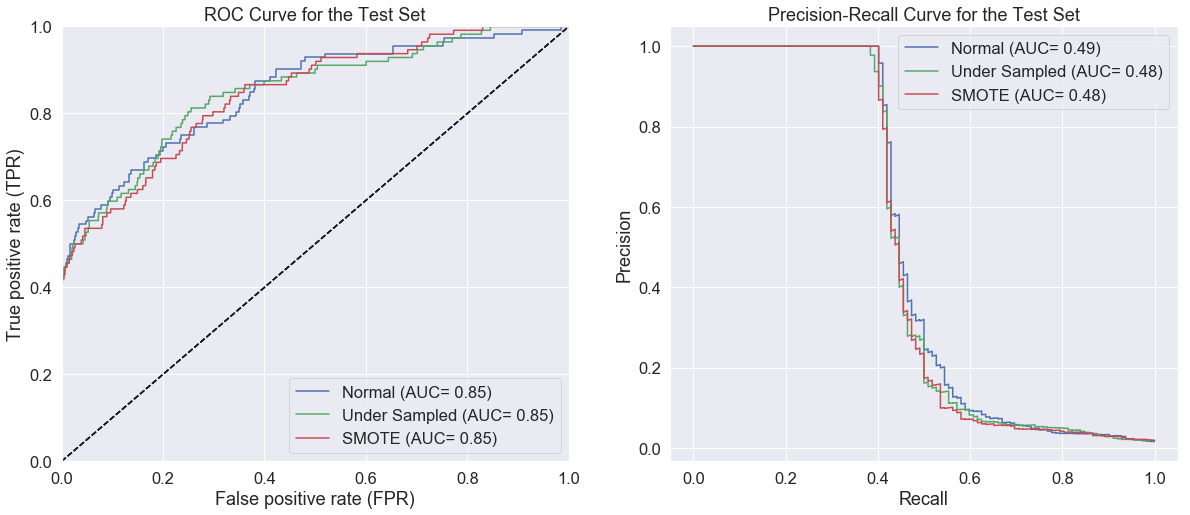

In [170]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})

# Plot ROC and PR curves for normal imbalanced distribution
xgb_best = xgb.XGBClassifier(n_estimators=1000, subsample=0.8, colsample_bytree=0.8,random_state=42,
                         max_depth =3, min_child_weight=5, learning_rate =0.1,reg_alpha =0.001,
                        scale_pos_weight = class_ratio, gamma=0.0) 

Plot_ROC_Curve_and_PRC(xgb_best, X_train_scale, y_train, X_test_scale, y_test,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Plot ROC and PR curves for Under Sampled distribution
Plot_ROC_Curve_and_PRC(xgb_und, X_train_scale_und, y_train_und, X_test_scale, y_test,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')

# Plot ROC and PR curves for  SMOTE distribution
Plot_ROC_Curve_and_PRC(xgb_ovsm, X_train_scale_ovsm, y_train_ovsm, X_test_scale, y_test,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)')

- We can see that the AUPRC of the normal imbalanced dataset is slightly higher (by 0.01\%) than undersampling and SMOTE.

# Conclusion

In conclusion, we have analysed the motor vehicle collision on public roads in Canada from 1999 to 2016. We explored and identified some of the main causes of fatal motor vehicle collision and we built a machine learning model to predict the fatal accident class, which is the minority class with only $2\%$ of the whole dataset.

From our exploratory data analysis, we found the following results:

1. The most fatal collision occured in the year 1999 and the least fatal collision occured in the year 2014.

2. Two in every 100 men involves in a fatal collision, whereas one in every 100 women involves in a fatal collision.

3. Most fatal collision are mainly caused by  teenagers between the age range 16 to 19 and they are mostly boys.

4. The vehicle model in the year 2000 & 2001 caused the most fatal collisions.

5. Most fatal collisions occur on weekends in the month of July and August (summer session).

6. Most fatal collisions due to visibility limitation.

Furthermore, we built a machine learning predictive model to classify fatal collisions from non-fatal collisions, where the former is only $2\%$ of the total observations resulting in a highly imbalanced dataset. The dataset contains over 6 million observations with numerous missing values. The missing values were delected and the resulting dataset still contains over 3 million observations. We built the predictive modeling with only $1\%$ of th total observation due to the capacity of our computer system. We found that XGBoost outperformed Random forest classifier on the training set, so we picked the former and optimized its AUPR and Recall, which were chosen as the performance measure. 

The dataset was split into $80\%$ training set and $20\%$ test set. We modeled XGBoost classifier on the imbalanced training set using cost sensitive method, undersampling, and SMOTE.  On the cross-validation training set, SMOTE outperfomed other resampling methods by a high margin. However, on the imbalanced test set we obtain the following results:

In [219]:
pd.DataFrame({'Normal':[0.85,0.49,0.50,0.26], 'Undersampling': [0.85,0.48,0.62,0.07], 
               'SMOTE': [0.85,0.48,0.42,0.70]}, index = ['AUROC', 'AUPR', 'Recall', 'Precision'])

,Normal,Undersampling,SMOTE
AUROC,0.85,0.85,0.85
AUPR,0.49,0.48,0.48
Recall,0.50,0.62,0.42
Precision,0.26,0.07,0.70


These results show that we are able to predict the fatal accidents and the model can be used to predict the risk for fatal accident in the future. However, we beleive that these results can be improved in many ways, for example by using the whole dataset, tuning XGBoost properly, or adding interaction terms.

In [ ]:
# from numbers import Number
# from scipy import stats

# var_list = ['C_YEAR','C_MNTH','C_WDAY','C_HOUR','C_VEHS','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF',
# 'V_ID','V_TYPE','V_YEAR','P_ID','P_SEX','P_AGE','P_PSN','P_ISEV','P_SAFE','P_USER']
 
# CHI2 = []
# P =[]
# Variable =[]

# for k in var_list:
#     table = pd.crosstab(df['C_SEV'], df[k])
#     chi2, p, dof, expected = stats.chi2_contingency(table.values)
#     Variable.append(k)
#     CHI2.append(chi2)
#     P.append(p)
    
# pd.DataFrame({'Variable': Variable, 'Chi-Square':CHI2, 'P-Value':P })